In [31]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import shape
from census import Census
import matplotlib.pyplot as plt

In [38]:
def get_blockgroup_population(census_gdf, census_api_key=""):

    # Check for the census API key. First, look in the census_api_key parameter, then in the 'census_api_key.txt' file in the current directory
    if not census_api_key and os.path.exists("census_api_key.txt"):
        # Read the API key from the file
        with open("census_api_key.txt", "r") as file:
            census_api_key = file.read().strip()
    elif not census_api_key:
        raise ValueError("No API key was provided, and the 'census_api_key.txt' file is not found or empty. Please provide a valid API key from https://api.census.gov/data/key_signup.html.")

    # Gets state and county FIPS code. This assumes all entries are within same state, but allows for variability in number of counties
    state_fips = census_gdf.STATEFP[0]
    county_fips = census_gdf.COUNTYFP.unique()
    
    # Initialize the Census API with the provided key
    c = Census(census_api_key)


    census_pop = []

    # Retrieve census data by block group for the specified state and county
    # B01003_001E: Total population
    for county_fip in county_fips:
        data = c.acs5.state_county_blockgroup('B01003_001E', state_fips, county_fip, Census.ALL)
        census_pop.extend(data)

    census_pop_gdf = gpd.GeoDataFrame(census_pop)

    census_pop_gdf.rename(columns={'B01003_001E': 'POP'}, inplace=True)

    # Create the 'GEOID' column by concatenating the 'state', 'county', 'tract', and 'block group' fields
    census_pop_gdf['GEOID'] = census_pop_gdf['state'] + census_pop_gdf['county'] + census_pop_gdf['tract'] + census_pop_gdf['block group']

    # Deletes extraneous columns
    census_pop_gdf = census_pop_gdf.drop(columns=['state', 'county', 'tract', 'block group'])

    census_gdf = census_gdf.merge(census_pop_gdf, on='GEOID', how='left')
    census_gdf = census_gdf.set_geometry('geometry')

    area_sqkm = (census_gdf['ALAND']) / 10**6

    # Create population density column
    census_gdf['POPDENSITY'] = census_gdf['POP'] / area_sqkm

    census_gdf['NORMPOPDENSITY'] = (census_gdf['POPDENSITY'] - census_gdf['POPDENSITY'].min()) / \
    (census_gdf['POPDENSITY'].max() - census_gdf['POPDENSITY'].min())


    return census_gdf


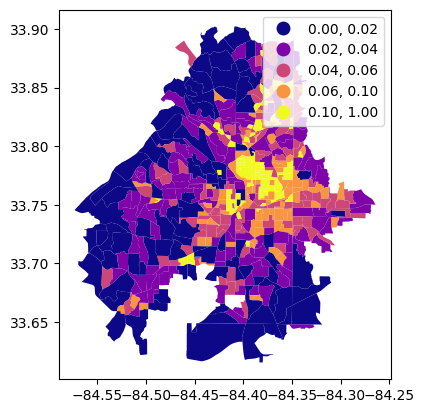

In [43]:
census_gdf = gpd.read_file('atl_bg.geojson')
census_gdf = get_blockgroup_population(census_gdf)


normpopdensity = census_gdf['NORMPOPDENSITY']

# Calculate quintile values
q1 = round(np.percentile(normpopdensity, 20),2)
q2 = round(np.percentile(normpopdensity, 40),2)
q3 = round(np.percentile(normpopdensity, 60),2)
q4 = round(np.percentile(normpopdensity, 80),2)


#labels = [f"0.00-{quintile1}", f"{quintile1 + 0.01}-{quintile2}", f"{quintile2 + 0.01}-{quintile3}", f"{quintile3 + 0.01}-{quintile4}", f"{quintile4 + 0.01}-1.00"]

fig, ax = plt.subplots()

census_gdf.plot(column='NORMPOPDENSITY', cmap='plasma', scheme="User_Defined", 
         legend=True, classification_kwds=dict(bins=[q1, q2, q3, q4]),
         ax=ax)

plt.show()


#print(labels)
#bins = pd.qcut(census_gdf['NORMPOPDENSITY'], 5, labels=labels)


